# Thinking with Deep Learning: Week 4 Part 2
# Advanced Deep Learning for Text

__Instructor:__ James Evans

__Teaching Assistants & Content Creators/Organisers:__ Bhargav Srinivasa Desikan, Likun Cao

In this notebook, we will be exploring different state of the art deep learning models. Most of these methods are based on powerful encoder-decoder systems called Transformer, and a certain alignment trick called Attention. 

Throughout this tutorial, we will link to endorsed resources and blog posts which we highly recommend reading before diving into the code. The purpose of this notebook is to accustom you to the power of these large, pre-trained language models. We will explore most of the standard tasks which one can do using these Transformers, as well as visualisations to better understand what makes a language model tick.

NOTE: the first two sections of this tutorial introduce sequence to sequence models, with and without attention. We use machine language translation between french and english as the example, but note that we can use any sequence to sequence pair (Question-Answer, Human-Chatbot, etc).

NOTE: As usual, we advice you to check the HW first - we focus on testing your use of the transformers models, with an optional question (for extra credit) on sequence to sequence tasks.


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 6.2MB/s 
     |████████████████████████████████| 3.3MB 23.4MB/s 
     |████████████████████████████████| 901kB 42.7MB/s 


# Encoders, Decoders, Seq2Seq and Attention

Encoder-Decoder models are a powerful way to deal with sequence to sequence problems - this kind of setup is also called seq2seq.

When we use this kind of sequence to sequence alignment and also map certain parts of the sequences with different values (a process called Attention), the sequence to sequence prediction task performance increases. In this section and the next we will focus on Machine Translation as the domain to try Encoder and Decoder tasks, without and with attention. 

**We highly recommend using this [visual blog](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) which explains seq2seq and attention based models**

We will be using the code from a Keras tutorial and PyTorch tutorial to demonstrate these models.

NOTE: these sections can be skimmed through - you can go through these in detail if you decide to do the HW question on sequence to sequence pairs.

In [ ]:
# empty cell

## Character-level recurrent sequence-to-sequence model

This code is adapted from the [Keras official tutorial](https://keras.io/examples/nlp/lstm_seq2seq/) on seq2seq using LSTM, authored by [fchollet](https://twitter.com/fchollet). 

### Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


### Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


### Download the data


In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip


### Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"


### Prepare the data


In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


### Build the model


In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


### Train the model


In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


### Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)



##  Translation with a Sequence to Sequence Network and Attention

This code is adapted from the [PyTorch official tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), authored by [Sean Robertson](https://github.com/spro/practical-pytorch).




### Introduction
In this project we will be teaching a neural network to translate from
French to English.


    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

### imports

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data files


The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

### The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.






In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



### Training

Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

### Visualizing Attention


A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Transformers

Transformers are a neural architecture comprised of encoder component and a decoder component, which uses self attention to reach high levels of performance for sequence to sequence tasks (and drops all RNN components!).

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-transformer/) on the Transformer before proceeding.**


## Models

We usually see two families of models - the Generative Pre-Trained Transformer models (GPT-n), and the BERT family of models, which featured Bi-directional Transformers as language models.

### GPT and similar models

These are auto-regressive language models created by [OpenAI](https://openai.com/). GPT3 has 175 billion parameters and is one of the largest, most powerful generative language model available today.

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-gpt2/) on the GPT-2 before proceeding.**


### BERT and similar models

The BERT model, first presented by Google Research, uses bi directional transformers and two tasks - Masked Language Modelling task, and Next Sentence Prediction task, to train the model. These large transformers based models are trained on lots of data (Wikipedia + books). BERT has since spun off many models, include language specific ones (SpanBERT), domain specific models (SciBERT), and different level of sequences (CharacterBERT). 

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-bert/) on BERT and similar models before proceeding**.

Since BERT, the state of the art has constatly been beat by models such as XL-Net. We recommend this [blog post](https://medium.com/@phylypo/a-survey-of-the-state-of-the-art-language-models-up-to-early-2020-aba824302c6) which describes various language models as of 2020 (right before GPT-3 burst on the scene). 

We also highly recommend these papers for a more critical view on such language models:

[On the Dangers of Stochastic Parrots: Can Language Models Be Too Big? 🦜](https://dl.acm.org/doi/10.1145/3442188.3445922) - Bender et al, 2021

[Climbing towards NLU: On Meaning, Form, and Understanding in the Age of Data](https://www.aclweb.org/anthology/2020.acl-main.463/) - Bender and Koller, 2020


In [ ]:
# empty cell

## Popular Tasks using Transformers 

We will now use the popular Transformers package default 'pipelines' feature to explore common NLP tasks.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification

Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset, which is entirely based on that task. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sequence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question.', score: 0.6226, start: 34, end: 96
Answer: 'SQuAD dataset,', score: 0.5053, start: 147, end: 161

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2 . 0 and pytorch

### Language Modeling

Language modeling is the task of fitting a model to a corpus, which can be domain specific. All popular
transformer-based models are trained using a variant of language modeling, e.g. BERT with masked language modeling,
GPT-2 with causal language modeling.

Language modeling can be useful outside of pretraining as well, for example to shift the model distribution to be
domain-specific: using a language model trained over a very large corpus, and then fine-tuning it to a news dataset or
on scientific papers e.g. [LysandreJik/arxiv-nlp](https://huggingface.co/lysandre/arxiv-nlp).

#### Masked Language Modeling

Masked language modeling is the task of masking tokens in a sequence with a masking token, and prompting the model to
fill that mask with an appropriate token. This allows the model to attend to both the right context (tokens on the
right of the mask) and the left context (tokens on the left of the mask). Such a training creates a strong basis for
downstream tasks requiring bi-directional context, such as SQuAD (question answering, see [Lewis, Lui, Goyal et al.](https://arxiv.org/abs/1910.13461), part 4.2).

Here is an example of using pipelines to replace a mask from a sequence:

In [ ]:
from transformers import pipeline
nlp = pipeline("fill-mask")

This outputs the sequences with the mask filled, the confidence score, and the token id in the tokenizer vocabulary:

In [ ]:
from pprint import pprint
pprint(nlp(f"HuggingFace is creating a {nlp.tokenizer.mask_token} that the community uses to solve NLP tasks."))

[{'score': 0.1792745739221573,
  'sequence': '<s>HuggingFace is creating a tool that the community uses to '
              'solve NLP tasks.</s>',
  'token': 3944,
  'token_str': 'Ġtool'},
 {'score': 0.11349421739578247,
  'sequence': '<s>HuggingFace is creating a framework that the community uses '
              'to solve NLP tasks.</s>',
  'token': 7208,
  'token_str': 'Ġframework'},
 {'score': 0.05243554711341858,
  'sequence': '<s>HuggingFace is creating a library that the community uses to '
              'solve NLP tasks.</s>',
  'token': 5560,
  'token_str': 'Ġlibrary'},
 {'score': 0.03493533283472061,
  'sequence': '<s>HuggingFace is creating a database that the community uses '
              'to solve NLP tasks.</s>',
  'token': 8503,
  'token_str': 'Ġdatabase'},
 {'score': 0.02860250137746334,
  'sequence': '<s>HuggingFace is creating a prototype that the community uses '
              'to solve NLP tasks.</s>',
  'token': 17715,
  'token_str': 'Ġprototype'}]

Here is an example of doing masked language modeling using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a DistilBERT model and
   loads it with the weights stored in the checkpoint.
2. Define a sequence with a masked token, placing the `tokenizer.mask_token` instead of a word.
3. Encode that sequence into a list of IDs and find the position of the masked token in that list.
4. Retrieve the predictions at the index of the mask token: this tensor has the same size as the vocabulary, and the
   values are the scores attributed to each token. The model gives higher score to tokens it deems probable in that
   context.
5. Retrieve the top 5 tokens using the PyTorch `topk` or TensorFlow `top_k` methods.
6. Replace the mask token by the tokens and print the results

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModelWithLMHead.from_pretrained("distilbert-base-cased")
sequence = f"Distilled models are smaller than the models they mimic. Using them instead of the large versions would help {tokenizer.mask_token} our carbon footprint."
input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

This prints five sequences, with the top 5 tokens predicted by the model:

In [ ]:
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Distilled models are smaller than the models they mimic. Using them instead of the large versions would help reduce our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help increase our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help decrease our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help offset our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help improve our carbon footprint.

#### Causal Language Modeling

Causal language modeling is the task of predicting the token following a sequence of tokens. In this situation, the
model only attends to the left context (tokens on the left of the mask). Such a training is particularly interesting
for generation tasks.

Usually, the next token is predicted by sampling from the logits of the last hidden state the model produces from the
input sequence.

Here is an example of using the tokenizer and model and leveraging the
`PreTrainedModel.top_k_top_p_filtering` method to sample the next token following an input sequence
of tokens.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer, top_k_top_p_filtering
import torch
from torch.nn import functional as F
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelWithLMHead.from_pretrained("gpt2")
sequence = f"Hugging Face is based in DUMBO, New York City, and "
input_ids = tokenizer.encode(sequence, return_tensors="pt")
# get logits of last hidden state
next_token_logits = model(input_ids).logits[:, -1, :]
# filter
filtered_next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)
# sample
probs = F.softmax(filtered_next_token_logits, dim=-1)
next_token = torch.multinomial(probs, num_samples=1)
generated = torch.cat([input_ids, next_token], dim=-1)
resulting_string = tokenizer.decode(generated.tolist()[0])

This outputs a (hopefully) coherent next token following the original sequence, which in our case is the word **has**:

In [ ]:
print(resulting_string)

Hugging Face is based in DUMBO, New York City, and has

In the next section, we show how this functionality is leveraged in `PreTrainedModel.generate` to
generate multiple tokens up to a user-defined length.

### Text Generation

In text generation (**a.k.a** **open-ended text generation**) the goal is to create a coherent portion of text that is a
continuation from the given context. The following example shows how **GPT-2** can be used in pipelines to generate text.
As a default all models apply **Top-K** sampling when used in pipelines, as configured in their respective configurations
(see [gpt-2 config](https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json) for example).

In [ ]:
from transformers import pipeline
text_generator = pipeline("text-generation")
print(text_generator("As far as I am concerned, I will", max_length=50, do_sample=False))

[{'generated_text': 'As far as I am concerned, I will be the first to admit that I am not a fan of the idea of a "free market." I think that the idea of a free market is a bit of a stretch. I think that the idea'}]

Here, the model generates a random text with a total maximal length of **50** tokens from context **"As far as I am
concerned, I will"**. The default arguments of `PreTrainedModel.generate()` can be directly overridden in the
pipeline, as is shown above for the argument `max_length`.

Here is an example of text generation using `XLNet` and its tokenizer.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("xlnet-base-cased")
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
# Padding text helps XLNet with short prompts - proposed by Aman Rusia in https://github.com/rusiaaman/XLNet-gen#methodology
PADDING_TEXT = """In 1991, the remains of Russian Tsar Nicholas II and his family
(except for Alexei and Maria) are discovered.
The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
remainder of the story. 1883 Western Siberia,
a young Grigori Rasputin is asked by his father and a group of men to perform magic.
Rasputin has a vision and denounces one of the men as a horse thief. Although his
father initially slaps him for making such an accusation, Rasputin watches as the
man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
with people, even a bishop, begging for his blessing. <eod> </s> <eos>"""
prompt = "Today the weather is really nice and I am planning on "
inputs = tokenizer.encode(PADDING_TEXT + prompt, add_special_tokens=False, return_tensors="pt")
prompt_length = len(tokenizer.decode(inputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))
outputs = model.generate(inputs, max_length=250, do_sample=True, top_p=0.95, top_k=60)
generated = prompt + tokenizer.decode(outputs[0])[prompt_length:]

In [ ]:
print(generated)

Today the weather is really nice and I am planning on anning on taking a nice...... of a great time!<eop>...............

Text generation is currently possible with **GPT-2**, **OpenAi-GPT**, **CTRL**, **XLNet**, **Transfo-XL** and **Reformer** in
PyTorch and for most models in Tensorflow as well. As can be seen in the example above **XLNet** and **Transfo-XL** often
need to be padded to work well. GPT-2 is usually a good choice for **open-ended text generation** because it was trained
on millions of webpages with a causal language modeling objective.

For more information on how to apply different decoding strategies for text generation, please also refer to our text
generation blog post [here](https://huggingface.co/blog/how-to-generate).

### Named Entity Recognition

Named Entity Recognition (NER) is the task of classifying tokens according to a class, for example, identifying a token
as a person, an organisation or a location. An example of a named entity recognition dataset is the CoNLL-2003 dataset,
which is entirely based on that task. If you would like to fine-tune a model on an NER task, you may leverage the
[run_ner.py](https://github.com/huggingface/transformers/tree/master/examples/token-classification/run_ner.py)
(PyTorch), [run_pl_ner.py](https://github.com/huggingface/transformers/tree/master/examples/token-classification/run_pl_ner.py) (leveraging
pytorch-lightning) or the [run_tf_ner.py](https://github.com/huggingface/transformers/tree/master/examples/token-classification/run_tf_ner.py) (TensorFlow)
scripts.

Here is an example of using pipelines to do named entity recognition, specifically, trying to identify tokens as
belonging to one of 9 classes:

- O, Outside of a named entity
- B-MIS, Beginning of a miscellaneous entity right after another miscellaneous entity
- I-MIS, Miscellaneous entity
- B-PER, Beginning of a person's name right after another person's name
- I-PER, Person's name
- B-ORG, Beginning of an organisation right after another organisation
- I-ORG, Organisation
- B-LOC, Beginning of a location right after another location
- I-LOC, Location

It leverages a fine-tuned model on CoNLL-2003, fine-tuned by [@stefan-it](https://github.com/stefan-it) from [dbmdz](https://github.com/dbmdz).

In [ ]:
from transformers import pipeline
nlp = pipeline("ner")
sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very"
           "close to the Manhattan Bridge which is visible from the window."

This outputs a list of all words that have been identified as one of the entities from the 9 classes defined above.
Here are the expected results:

In [ ]:
print(nlp(sequence))

[
    {'word': 'Hu', 'score': 0.9995632767677307, 'entity': 'I-ORG'},
    {'word': '##gging', 'score': 0.9915938973426819, 'entity': 'I-ORG'},
    {'word': 'Face', 'score': 0.9982671737670898, 'entity': 'I-ORG'},
    {'word': 'Inc', 'score': 0.9994403719902039, 'entity': 'I-ORG'},
    {'word': 'New', 'score': 0.9994346499443054, 'entity': 'I-LOC'},
    {'word': 'York', 'score': 0.9993270635604858, 'entity': 'I-LOC'},
    {'word': 'City', 'score': 0.9993864893913269, 'entity': 'I-LOC'},
    {'word': 'D', 'score': 0.9825621843338013, 'entity': 'I-LOC'},
    {'word': '##UM', 'score': 0.936983048915863, 'entity': 'I-LOC'},
    {'word': '##BO', 'score': 0.8987102508544922, 'entity': 'I-LOC'},
    {'word': 'Manhattan', 'score': 0.9758241176605225, 'entity': 'I-LOC'},
    {'word': 'Bridge', 'score': 0.990249514579773, 'entity': 'I-LOC'}
]

Note how the tokens of the sequence "Hugging Face" have been identified as an organisation, and "New York City",
"DUMBO" and "Manhattan Bridge" have been identified as locations.

Here is an example of doing named entity recognition, using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define the label list with which the model was trained on.
3. Define a sequence with known entities, such as "Hugging Face" as an organisation and "New York City" as a location.
4. Split words into tokens so that they can be mapped to predictions. We use a small hack by, first, completely
   encoding and decoding the sequence, so that we're left with a string that contains the special tokens.
5. Encode that sequence into IDs (special tokens are added automatically).
6. Retrieve the predictions by passing the input to the model and getting the first output. This results in a
   distribution over the 9 possible classes for each token. We take the argmax to retrieve the most likely class for
   each token.
7. Zip together each token with its prediction and print it.

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name right after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation right after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location right after another location
    "I-LOC"    # Location
]
sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")
outputs = model(inputs).logits
predictions = torch.argmax(outputs, dim=2)

This outputs a list of each token mapped to its corresponding prediction. Differently from the pipeline, here every
token has a prediction as we didn't remove the "0"th class, which means that no particular entity was found on that
token. The following array should be the output:

In [ ]:
print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())])

[('[CLS]', 'O'), ('Hu', 'I-ORG'), ('##gging', 'I-ORG'), ('Face', 'I-ORG'), ('Inc', 'I-ORG'), ('.', 'O'), ('is', 'O'), ('a', 'O'), ('company', 'O'), ('based', 'O'), ('in', 'O'), ('New', 'I-LOC'), ('York', 'I-LOC'), ('City', 'I-LOC'), ('.', 'O'), ('Its', 'O'), ('headquarters', 'O'), ('are', 'O'), ('in', 'O'), ('D', 'I-LOC'), ('##UM', 'I-LOC'), ('##BO', 'I-LOC'), (',', 'O'), ('therefore', 'O'), ('very', 'O'), ('##c', 'O'), ('##lose', 'O'), ('to', 'O'), ('the', 'O'), ('Manhattan', 'I-LOC'), ('Bridge', 'I-LOC'), ('.', 'O'), ('[SEP]', 'O')]

### Summarization

Summarization is the task of summarizing a document or an article into a shorter text.

An example of a summarization dataset is the CNN / Daily Mail dataset, which consists of long news articles and was
created for the task of summarization. If you would like to fine-tune a model on a summarization task, various
approaches are described in this [document](https://github.com/huggingface/transformers/blob/master/examples/seq2seq/README.md).

Here is an example of using the pipelines to do summarization. It leverages a Bart model that was fine-tuned on the CNN
/ Daily Mail data set.

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")
ARTICLE = """ New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""

Because the summarization pipeline depends on the `PreTrainedModel.generate()` method, we can override the default
arguments of `PreTrainedModel.generate()` directly in the pipeline for `max_length` and `min_length` as shown
below. This outputs the following summary:

In [ ]:
print(summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False))

[{'summary_text': 'Liana Barrientos, 39, is charged with two counts of "offering a false instrument for filing in the first degree" In total, she has been married 10 times, with nine of her marriages occurring between 1999 and 2002. She is believed to still be married to four men.'}]

Here is an example of doing summarization using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. Summarization is usually done using an encoder-decoder
   model, such as `Bart` or `T5`.
2. Define the article that should be summarized.
3. Add the T5 specific prefix "summarize: ".
4. Use the `PreTrainedModel.generate()` method to generate the summary.

In this example we use Google`s T5 model. Even though it was pre-trained only on a multi-task mixed dataset (including
CNN / Daily Mail), it yields very good results.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")
# T5 uses a max_length of 512 so we cut the article to 512 tokens.
inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", max_length=512)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

### Translation

We have already seen Translation examples early in this notebook. We will now use a different case with BERT.

An example of a translation dataset is the WMT English to German dataset, which has sentences in English as the input
data and the corresponding sentences in German as the target data. If you would like to fine-tune a model on a
translation task, various approaches are described in this [document](https://github.com/huggingface/transformers/blob/master/examples/seq2seq/README.md).

Here is an example of using the pipelines to do translation. It leverages a T5 model that was only pre-trained on a
multi-task mixture dataset (including WMT), yet, yielding impressive translation results.

In [ ]:
from transformers import pipeline
translator = pipeline("translation_en_to_de")
print(translator("Hugging Face is a technology company based in New York and Paris", max_length=40))

[{'translation_text': 'Hugging Face ist ein Technologieunternehmen mit Sitz in New York und Paris.'}]

Because the translation pipeline depends on the `PreTrainedModel.generate()` method, we can override the default
arguments of `PreTrainedModel.generate()` directly in the pipeline as is shown for `max_length` above.

Here is an example of doing translation using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. Summarization is usually done using an encoder-decoder
   model, such as `Bart` or `T5`.
2. Define the article that should be summarized.
3. Add the T5 specific prefix "translate English to German: "
4. Use the `PreTrainedModel.generate()` method to perform the translation.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")
inputs = tokenizer.encode("translate English to German: Hugging Face is a technology company based in New York and Paris", return_tensors="pt")
outputs = model.generate(inputs, max_length=40, num_beams=4, early_stopping=True)

As with the pipeline example, we get the same translation:

In [ ]:
print(tokenizer.decode(outputs[0]))

Hugging Face ist ein Technologieunternehmen mit Sitz in New York und Paris.

## Fine tuning models  

(section in progress - need to include classification task, language generation, and language modelling - code ready, need to plug in)

# BERT Word and Sentence Embeddings

In this section we will explore the many ways we can use BERT to generate word and sentence embeddings.





### Embeddings, Context Words

We saw how a bootstrapped BERT model performed so much better than a model trained from scatch. Because BERT's method of capturing context is bidirectional, meaning that words can now have different word embedding values based on their location within a sentence. Let us use the same BERT model to capture sentence and word embeddings. 

In [ ]:
from transformers import BertModel

Let's go through the sentence format for the BERT model, as well as how our vocabulary looks like. Note that you have to use the BERT tokenizer to use the BERT model because of the similar vocabulary.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


BERTS model uses a WordPiece technique to do its tokenizing, as described in the paper. That's why the word embedding is split up the way it is.
A quick peek at what the voabulary looks like:

In [ ]:
list(tokenizer.vocab.keys())[6000:6030]

['peninsula',
 'adults',
 'novels',
 'emerged',
 'vienna',
 'metro',
 'debuted',
 'shoes',
 'tamil',
 'songwriter',
 'meets',
 'prove',
 'beating',
 'instance',
 'heaven',
 'scared',
 'sending',
 'marks',
 'artistic',
 'passage',
 'superior',
 '03',
 'significantly',
 'shopping',
 '##tive',
 'retained',
 '##izing',
 'malaysia',
 'technique',
 'cheeks']

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


#### Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [ ]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Like we did for classification, we now convert these segments to tensors.

The embedding layer is the hidden state layer, and this is what we pick up.

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
output = model_embedding(tokens_tensor)

In [ ]:
# output

In [ ]:
len(output[0][0][0]), len(output[1][0])

(768, 768)

#### Understanding the Output

This kind of forward pass returns us the last layer of the net, which we will use to make our vectors. The first object returned contains the batch number, followed by each of the tokens and their vector values. The second object contains a vector value, which I suspect is the sentence vector of the tokens. 

The first index is the batch size, and our batch size is 1, so we just choose the 0th index and work with that.

In [ ]:
word_embeddings, sentence_embedding = output

In [ ]:
len(word_embeddings[0])

22

In [ ]:
word_embeddings[0]

tensor([[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
        [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
        [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
        ...,
        [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
        [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
        [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]],
       grad_fn=<SelectBackward>)

Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

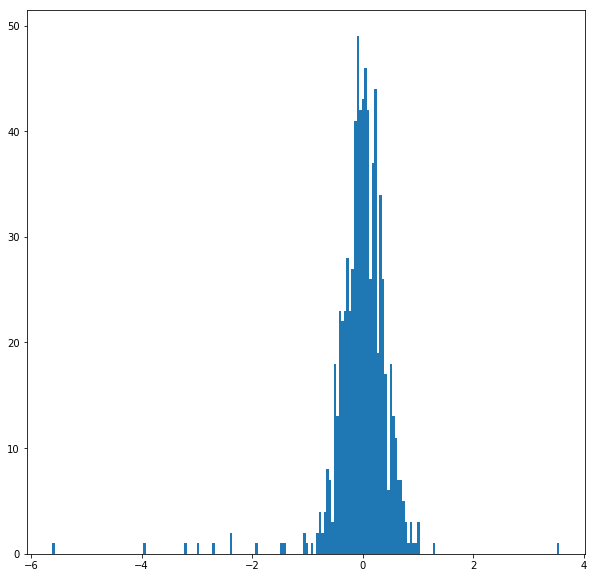

In [ ]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

These values are grouped by layer - we can use the permute function to make it grouped by each individual token instead. Let us look at what the later looks like:

#### Word Vectors

So each of those tokens have embedding values - let us try and compare them with each other.

In [ ]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [ ]:
len(token_vecs)

22

Another method to create the vectors is to sum the last four layers.

#### Sentence Vector

To get a single vector for our entire sentence we have multiple application-dependent strategies - we could just average all the tokens in our sentence. We can also use this oppurtunity to see if the second vector returned is a sentence vector too.

In [ ]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [ ]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [ ]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

Remember that the power of these vectors is how they are context dependant - our sentence had multiple uses of the word bank. Let us see the index and the word of the sentence and check the context accordingly. We'll then print the simlarity values for the similar and different meanings and see how it turns out.

In [ ]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs[6][:5]))
print("bank robber  ", str(token_vecs[10][:5]))
print("river bank   ", str(token_vecs[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    [ 0.9001056  -0.53804165 -0.16690847  0.22416186  0.6896585 ]
bank robber   [ 0.7977126  -0.52172744 -0.1983698   0.18898535  0.59409326]
river bank    [ 0.29608926 -0.28563383 -0.03818326  0.16736214  0.7712624 ]


In [ ]:
from scipy.spatial.distance import cosine


In [ ]:

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs[10], token_vecs[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs[10], token_vecs[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.70


This makes sense! Let us see if the mean value of all the tokens and what we think is the sentence vector is the same thing, by checking their cosine distance.

In [ ]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.008313187398016453

That is good - it seems it is indeed the sentence vector, so we can now write two functions which calculate the word and sentence vectors.

In [ ]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [ ]:
word_10 = word_vector(text, 6, model_embedding, tokenizer)
word_6 = word_vector(text, 10, model_embedding, tokenizer)
word_19 = word_vector(text, 19, model_embedding, tokenizer)

In [ ]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [ ]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

#### Similarity metrics
It is worth noting that word-level similarity comparisons are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This enables direct sensitivity to polysemy so that, e.g., your representation encodes river “bank” and not a financial institution “bank”. Nevertheless, it makes direct word-to-word similarity comparisons less valuable. For sentence embeddings, however, similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs as some similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.

### Using the Vectors

Without fine-tuning, BERT features may be less useful than plain GloVe or word2vec.
They start to be interesting when you fine-tune a classifier on top of BERT. 



### Contextual Sentence Embeddings

Standard BERT sentence embeddings don't perform as well as special architectures built for sentence embeddings, such as BERT siamese networks. 

We will use the [UKPLab package "sentence transformers"](https://github.com/UKPLab/sentence-transformers
), which implement such methods.

- Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (EMNLP 2019)
- Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation (EMNLP 2020)
- Augmented SBERT: Data Augmentation Method for Improving Bi-Encoders for Pairwise Sentence Scoring Tasks (NAACL 2021)
- The Curse of Dense Low-Dimensional Information Retrieval for Large Index Sizes (arXiv 2020)

Documentation for [SBERT](https://www.sbert.net/examples/applications/computing-embeddings/README.html).



In [6]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 1.7MB/s 
     |████████████████████████████████| 1.2MB 7.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=b427cc6a7d0e8f153402a465b37a734214353f478ccdd98d3f9968fda4a04484
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
Successfully built sentence-transformers


In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')


In [8]:

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

In [9]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

In [10]:
#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-2.14861646e-01  3.95723283e-01  4.69087005e-01  1.36177391e-01
  6.91134529e-03  4.29976672e-01  1.03049493e+00 -8.20221826e-02
  2.20890775e-01 -8.78799498e-01 -1.11538105e-01 -1.70814916e-01
 -4.95070279e-01 -3.25745046e-01 -1.68513298e-01 -7.61576772e-01
 -3.08237225e-01  1.28200486e-01  2.28901401e-01 -8.63927901e-01
  8.01117897e-01 -5.13606787e-01 -8.88547152e-02  8.67859423e-01
  8.12777877e-01 -2.80298680e-01  1.01604247e+00  5.12090147e-01
  5.16793191e-01 -1.59421980e-01  8.63558426e-02 -7.04056799e-01
 -4.15288240e-01 -1.02645140e-02  1.39428526e-01 -7.40843220e-03
 -2.75418386e-02 -1.06805253e+00 -1.14779401e+00 -4.22716290e-01
  2.93512702e-01 -3.92946452e-01  3.17559600e-01 -1.97931565e-02
 -5.53470194e-01  4.99457214e-03 -5.46877012e-02  5.82734048e-01
 -1.38893008e+00 -4.44052726e-01 -8.77214193e-01 -1.82058096e-01
  4.69049871e-01 -6.04763150e-01 -3.85194331e-01 -1.42893810e-02
 -4.25226

We recommend visiting the documentation to view other uses of these sentence embeddings, such as [clustering](https://www.sbert.net/examples/applications/clustering/README.html), [Paraphrase Mining](https://www.sbert.net/examples/applications/paraphrase-mining/README.html), [Semantic Search](https://www.sbert.net/examples/applications/semantic-search/README.html), [Retreive and Rank](https://www.sbert.net/examples/applications/retrieve_rerank/README.html), and even multi-modal [Image Search](https://www.sbert.net/examples/applications/image-search/README.html).

# BERTology

"BERTology" refers to the growing number of papers disecting BERT and it's inner workings. 

- [A Primer in BERTology: What we know about how BERT works](https://arxiv.org/abs/2002.12327)

- [Huggingface Transformers page on BERTology](https://huggingface.co/transformers/bertology.html)

### Visualizing Attention

Visualising the Attention layers are a popular way to understand BERT.

**We highly recommend this visual blog on [explaining Transformers](http://jalammar.github.io/explaining-transformers/
) and this visual blog on [visualising hidden states](http://jalammar.github.io/hidden-states/
) before proceeding**

The package "bertviz" [(GitHub link)](https://github.com/jessevig/bertviz) allows us to look into specific layers of multiple Transformers based models.

This [blog post](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1) walks through the architecture of BERT and what exactly we can visualise.


In [ ]:
# code which visualises BERT

# Homework

In this notebook we saw some of the state of the art language models, as well as sequence to sequence models which served as the very early versions of such models. Text and language models had its own ImageNet moment with the deluge of large pre-trained language models in 2018 and onwards.

For the homework, you will be using BERT, GPT, or a similar large Transformer based model to analyse your social scientific textual dataset.

There are a total of 6 standard questions, you will be graded for 4/6, and there are two bonus questions.

**1a)** Use a large pre-trained language model for sequence classication, question answering, language modelling, or any other NLP task. Fine-tune the model on your dataset.

**1b)** What model did you use? How did your model perform?

**2a)** Use a different large pre-trained language model for sequence classication, question answering, language modelling, or any other NLP task. Fine-tune the model on your dataset.

**2b)** What model did you use? How did your model perform?

**3a)** Use BERT or a related model to create word and sentence embeddings from your corpus, and perform different similarity metrics on your embeddings.

**3b)** How does fine-tuning your model change the similarity metrics?

**4)** BONUS: Fine tune a Transformers based model and use bertviz to visualise its attention layers.

**5)** BONUS: use a PyTorch or Keras sequence to sequence model to perform a task other than machine translation.